# CS3244 Project kNN 

This file contains the code for the kNN model for fraud detection in electricity and gas consumption.

### Importing datasets and packages

In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler

from matplotlib.cm import viridis
from matplotlib.colors import to_hex
import matplotlib.pyplot as plt

import optuna
from sklearn.model_selection import cross_val_score
from sklearn import neighbors
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
fold1 = pd.read_csv('finalised_datasets/smote_train_data/fold_1.csv')
fold2 = pd.read_csv('finalised_datasets/smote_train_data/fold_2.csv')
fold3 = pd.read_csv('finalised_datasets/smote_train_data/fold_3.csv')
fold4 = pd.read_csv('finalised_datasets/smote_train_data/fold_4.csv')
fold5 = pd.read_csv('finalised_datasets/smote_train_data/fold_5.csv')

smote_fold_1 = pd.read_csv('finalised_datasets/smote_train_data/smote_fold_1.csv')
smote_fold_2 = pd.read_csv('finalised_datasets/smote_train_data/smote_fold_2.csv')
smote_fold_3 = pd.read_csv('finalised_datasets/smote_train_data/smote_fold_3.csv')
smote_fold_4 = pd.read_csv('finalised_datasets/smote_train_data/smote_fold_4.csv')
smote_fold_5 = pd.read_csv('finalised_datasets/smote_train_data/smote_fold_5.csv')

test_set = pd.read_csv('finalised_datasets/transformed_data/test_set.csv')

In [3]:
train_data = pd.concat([smote_fold_1, smote_fold_2, smote_fold_3, smote_fold_4])
val_data = fold5

display(train_data)
display(val_data)

,creation_year,creation_month,creation_day,region_101,region_103,region_104,region_105,region_106,region_107,region_199,...,meter_coefficient_50,reading_remark_6,reading_remark_7,reading_remark_8,reading_remark_9,meter_type_0,meter_type_1,is_index_discrepancy_False,is_index_discrepancy_True,fraud_status
0,1985,2,5,0,0,1,0,0,0,0,...,0.0,12.000000,0.0,0.000000,2.000000,8.000000,6.000000,14.000000,0.000000,0.0
1,1996,12,31,0,0,0,0,0,0,0,...,0.0,53.000000,0.0,10.000000,3.000000,32.000000,34.000000,66.000000,0.000000,0.0
2,1999,9,8,1,0,0,0,0,0,0,...,0.0,19.000000,0.0,14.000000,1.000000,34.000000,0.000000,34.000000,0.000000,0.0
3,2016,4,25,0,0,0,0,0,0,0,...,0.0,0.000000,0.0,0.000000,6.000000,6.000000,0.000000,6.000000,0.000000,0.0
4,2008,11,22,1,0,0,0,0,0,0,...,0.0,7.000000,0.0,7.000000,16.000000,30.000000,0.000000,30.000000,0.000000,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
40951,2001,5,7,0,0,1,0,0,0,0,...,0.0,29.051793,0.0,10.115537,15.111554,34.665339,19.613545,54.223107,0.055777,1.0
40952,2005,5,11,0,0,0,0,0,0,0,...,0.0,20.270349,0.0,9.719186,26.188954,34.367442,21.811046,56.178488,0.000000,1.0
40953,1984,11,21,0,0,0,0,0,0,0,...,0.0,21.886777,0.0,9.000000,0.238548,31.125325,0.000000,31.125325,0.000000,1.0
40954,2010,6,21,0,0,0,0,0,0,0,...,0.0,12.700108,0.0,8.288482,14.288482,17.638536,17.638536,35.019376,0.257696,1.0


,creation_year,creation_month,creation_day,region_101,region_103,region_104,region_105,region_106,region_107,region_199,...,meter_coefficient_50,reading_remark_6,reading_remark_7,reading_remark_8,reading_remark_9,meter_type_0,meter_type_1,is_index_discrepancy_False,is_index_discrepancy_True,fraud_status
0,1989,12,29,0,0,0,0,0,0,0,...,0.0,22.0,0.0,5.0,13.0,40.0,0.0,40.0,0.0,0.0
1,1984,11,12,0,0,1,0,0,0,0,...,0.0,52.0,0.0,11.0,3.0,35.0,31.0,66.0,0.0,1.0
2,2010,5,5,1,0,0,0,0,0,0,...,0.0,22.0,0.0,7.0,0.0,17.0,12.0,28.0,1.0,0.0
3,1998,6,23,1,0,0,0,0,0,0,...,0.0,1.0,0.0,1.0,1.0,3.0,0.0,3.0,0.0,0.0
4,1999,12,22,0,0,0,0,0,0,0,...,0.0,38.0,0.0,17.0,1.0,34.0,22.0,56.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21673,2007,9,6,0,0,0,0,0,0,0,...,0.0,12.0,0.0,11.0,12.0,35.0,0.0,35.0,0.0,0.0
21674,2012,10,13,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,4.0,4.0,0.0,4.0,0.0,0.0
21675,2018,11,10,0,0,1,0,0,0,0,...,0.0,1.0,0.0,0.0,2.0,3.0,0.0,3.0,0.0,0.0
21676,2010,1,8,0,0,0,0,0,1,0,...,0.0,5.0,0.0,0.0,0.0,3.0,2.0,5.0,0.0,0.0


### Feature scaling of numerical data

In [4]:
numerical_features = train_data.drop(columns=['fraud_status', 'region_101',
                   'region_103', 'region_104', 'region_105', 'region_106', 'region_107',
                   'region_199', 'region_206', 'region_301', 'region_302', 'region_303',
                   'region_304', 'region_305', 'region_306', 'region_307', 'region_308',
                   'region_309', 'region_310', 'region_311', 'region_312', 'region_313',
                   'region_371', 'region_372', 'region_379', 'region_399', 'district_60',
                   'district_62', 'district_63', 'district_69', 'client_catg_11', 'client_catg_12',
                   'client_catg_51']).columns

numerical_features = list(numerical_features)

print(numerical_features)

['creation_year', 'creation_month', 'creation_day', 'consumption_level_1_mean', 'consumption_level_1_std', 'consumption_level_1_min', 'consumption_level_1_max', 'consumption_level_1_median', 'consumption_level_1_sum', 'consumption_level_2_mean', 'consumption_level_2_std', 'consumption_level_2_min', 'consumption_level_2_max', 'consumption_level_2_median', 'consumption_level_2_sum', 'consumption_level_3_mean', 'consumption_level_3_std', 'consumption_level_3_min', 'consumption_level_3_max', 'consumption_level_3_median', 'consumption_level_3_sum', 'consumption_level_4_mean', 'consumption_level_4_std', 'consumption_level_4_min', 'consumption_level_4_max', 'consumption_level_4_median', 'consumption_level_4_sum', 'old_index_mean', 'old_index_std', 'old_index_min', 'old_index_max', 'old_index_median', 'diff_in_index_mean', 'diff_in_index_std', 'diff_in_index_min', 'diff_in_index_max', 'diff_in_index_median', 'diff_in_index_sum', 'total_consumption_mean', 'total_consumption_std', 'total_consump

In [5]:
# Initialize the StandardScaler
scaler = StandardScaler()

# Fit the scaler with the training data and scale the data.
data_scaled = train_data.copy()
data_scaled[numerical_features] = scaler.fit_transform(data_scaled[numerical_features])

# Display the scaled data
display(data_scaled)

,creation_year,creation_month,creation_day,region_101,region_103,region_104,region_105,region_106,region_107,region_199,...,meter_coefficient_50,reading_remark_6,reading_remark_7,reading_remark_8,reading_remark_9,meter_type_0,meter_type_1,is_index_discrepancy_False,is_index_discrepancy_True,fraud_status
0,-1.455067,-1.573595,-1.543134,0,0,1,0,0,0,0,...,-0.002471,-0.452869,-0.03849,-1.207292,-0.889624,-1.160965,-0.462739,-0.962619,-0.077829,0.0
1,-0.436057,1.520521,1.699058,0,0,0,0,0,0,0,...,-0.002471,2.005459,-0.03849,0.381412,-0.805323,0.318297,1.422745,0.995071,-0.077829,0.0
2,-0.158145,0.592286,-1.169035,1,0,0,0,0,0,0,...,-0.002471,-0.033154,-0.03849,1.016894,-0.973925,0.441569,-0.866772,-0.209662,-0.077829,0.0
3,1.416689,-0.954772,0.950860,0,0,0,0,0,0,0,...,-0.002471,-1.172380,-0.03849,-1.207292,-0.552421,-1.284237,-0.866772,-1.263802,-0.077829,0.0
4,0.675590,1.211109,0.576761,1,0,0,0,0,0,0,...,-0.002471,-0.752665,-0.03849,-0.095199,0.290586,0.195025,-0.866772,-0.360253,-0.077829,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
40951,0.027129,-0.645360,-1.293735,0,0,1,0,0,0,0,...,-0.002471,0.569543,-0.03849,0.399768,0.215689,0.482578,0.453979,0.551696,-0.046520,1.0
40952,0.397679,-0.645360,-0.794936,0,0,0,0,0,0,0,...,-0.002471,0.043015,-0.03849,0.336799,1.149522,0.464217,0.601956,0.625312,-0.077829,1.0
40953,-1.547705,1.211109,0.452061,0,0,0,0,0,0,0,...,-0.002471,0.139935,-0.03849,0.222542,-1.038116,0.264386,-0.866772,-0.317887,-0.077829,1.0
40954,0.860865,-0.335949,0.452061,0,0,0,0,0,0,0,...,-0.002471,-0.410891,-0.03849,0.109503,0.146304,-0.566885,0.320985,-0.171284,0.066822,1.0


kNN relies on distance metrics (e.g., Euclidean, Manhattan). Features with large scales can dominate the distance calculations. StandardScaler was applied to normalize features to have zero mean and unit variance. Standardization prevents bias due to differing feature scales and improves the accuracy of distance-based methods like kNN.

In [6]:
# Transform the validation data with the scaler
val_data_scaled = val_data.copy()
val_data_scaled[numerical_features] = scaler.transform(val_data_scaled[numerical_features])

# Display the scaled data
display(val_data_scaled)

,creation_year,creation_month,creation_day,region_101,region_103,region_104,region_105,region_106,region_107,region_199,...,meter_coefficient_50,reading_remark_6,reading_remark_7,reading_remark_8,reading_remark_9,meter_type_0,meter_type_1,is_index_discrepancy_False,is_index_discrepancy_True,fraud_status
0,-1.084518,1.520521,1.449659,0,0,0,0,0,0,0,...,-0.002471,0.146723,-0.03849,-0.412940,0.037684,0.811385,-0.866772,0.016226,-0.077829,0.0
1,-1.547705,1.211109,-0.670236,0,0,1,0,0,0,0,...,-0.002471,1.945500,-0.03849,0.540283,-0.805323,0.503205,1.220729,0.995071,-0.077829,1.0
2,0.860865,-0.645360,-1.543134,1,0,0,0,0,0,0,...,-0.002471,0.146723,-0.03849,-0.095199,-1.058226,-0.606242,-0.058707,-0.435549,0.483493,0.0
3,-0.250782,-0.335949,0.701461,1,0,0,0,0,0,0,...,-0.002471,-1.112420,-0.03849,-1.048421,-0.973925,-1.469145,-0.866772,-1.376746,-0.077829,0.0
4,-0.158145,1.520521,0.576761,0,0,0,0,0,0,0,...,-0.002471,1.106071,-0.03849,1.493505,-0.973925,0.441569,0.614680,0.618592,-0.077829,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21673,0.582953,0.592286,-1.418435,0,0,0,0,0,0,0,...,-0.002471,-0.452869,-0.03849,0.540283,-0.046617,0.503205,-0.866772,-0.172014,-0.077829,0.0
21674,1.046140,0.901698,-0.545537,0,0,0,0,0,0,0,...,-0.002471,-1.172380,-0.03849,-1.207292,-0.721023,-1.407509,-0.866772,-1.339098,-0.077829,0.0
21675,1.601963,1.211109,-0.919636,0,0,1,0,0,0,0,...,-0.002471,-1.112420,-0.03849,-1.207292,-0.889624,-1.469145,-0.866772,-1.376746,-0.077829,0.0
21676,0.860865,-1.883007,-1.169035,0,0,0,0,0,1,0,...,-0.002471,-0.872583,-0.03849,-1.207292,-1.058226,-1.469145,-0.732094,-1.301450,-0.077829,0.0


### Building the model

In [7]:
X_train = data_scaled.drop(columns=['fraud_status'])
y_train = data_scaled['fraud_status']

X_test = val_data_scaled.drop(columns=['fraud_status'])
y_test = val_data_scaled['fraud_status']

In [10]:
# Take a 50% sample of the training data for tuning
sample_size = int(0.5 * len(X_train))
sample_indices = np.random.choice(len(X_train), sample_size, replace=False)
X_sample = X_train.iloc[sample_indices]
y_sample = y_train.iloc[sample_indices]

In [17]:
# Define the metrics and the number of trials per metric
metrics = ['manhattan', 'euclidean', 'chebyshev']
trials_per_metric = 10  # Number of trials for each metric
total_trials = len(metrics) * trials_per_metric

def objective(trial):
    # Manually assign a metric based on trial number
    metric_idx = trial.number % len(metrics)
    metric = metrics[metric_idx]

    n_neighbors = trial.suggest_int('n_neighbors', 1, 21, step=2)
    trial.set_user_attr("metric", metric)

    knn = neighbors.KNeighborsClassifier(
        n_neighbors=n_neighbors,
        metric=metric,
        weights='distance'
    )
    
    score = cross_val_score(knn, X_sample, y_sample, cv=3, scoring='f1_weighted').mean()
    return score      

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=total_trials, show_progress_bar=True, n_jobs=-1)

best_trial = study.best_trial
best_metric = best_trial.user_attrs["metric"]

print("Best parameters:", study.best_params)
print("Best metric:", best_metric)
print("Best cross-validation F1-score:", study.best_value)

[I 2024-11-29 12:01:51,418] A new study created in memory with name: no-name-968c98d1-999f-468b-aecf-1c484735cbc7
Best trial: 7. Best value: 0.871046:   3%|▎         | 1/30 [02:06<1:01:17, 126.81s/it]

[I 2024-11-29 12:03:58,383] Trial 7 finished with value: 0.8710458890557913 and parameters: {'n_neighbors': 5}. Best is trial 7 with value: 0.8710458890557913.


Best trial: 7. Best value: 0.871046:   7%|▋         | 2/30 [02:07<24:33, 52.63s/it]   

[I 2024-11-29 12:03:59,083] Trial 4 finished with value: 0.8553864874179328 and parameters: {'n_neighbors': 9}. Best is trial 7 with value: 0.8710458890557913.
[I 2024-11-29 12:03:59,166] Trial 1 finished with value: 0.8629134380880391 and parameters: {'n_neighbors': 7}. Best is trial 7 with value: 0.8710458890557913.


Best trial: 7. Best value: 0.871046:  13%|█▎        | 4/30 [04:10<25:15, 58.27s/it]

[I 2024-11-29 12:06:02,356] Trial 10 finished with value: 0.8553864874179328 and parameters: {'n_neighbors': 9}. Best is trial 7 with value: 0.8710458890557913.


Best trial: 3. Best value: 0.882713:  17%|█▋        | 5/30 [23:01<2:42:30, 390.03s/it]

[I 2024-11-29 12:24:53,186] Trial 3 finished with value: 0.8827128742440583 and parameters: {'n_neighbors': 15}. Best is trial 3 with value: 0.8827128742440583.


Best trial: 3. Best value: 0.882713:  20%|██        | 6/30 [23:02<1:48:15, 270.64s/it]

[I 2024-11-29 12:24:53,657] Trial 2 finished with value: 0.816264429627593 and parameters: {'n_neighbors': 17}. Best is trial 3 with value: 0.8827128742440583.


Best trial: 0. Best value: 0.889067:  23%|██▎       | 7/30 [23:55<1:18:20, 204.37s/it]

[I 2024-11-29 12:25:46,615] Trial 0 finished with value: 0.889067211481223 and parameters: {'n_neighbors': 11}. Best is trial 0 with value: 0.889067211481223.


Best trial: 0. Best value: 0.889067:  27%|██▋       | 8/30 [24:05<53:24, 145.64s/it]  

[I 2024-11-29 12:25:57,287] Trial 6 finished with value: 0.8827128742440583 and parameters: {'n_neighbors': 15}. Best is trial 0 with value: 0.889067211481223.


Best trial: 0. Best value: 0.889067:  30%|███       | 9/30 [25:28<44:19, 126.65s/it]

[I 2024-11-29 12:27:20,075] Trial 13 finished with value: 0.8553864874179328 and parameters: {'n_neighbors': 9}. Best is trial 0 with value: 0.889067211481223.


Best trial: 9. Best value: 0.909687:  33%|███▎      | 10/30 [25:51<31:46, 95.32s/it]

[I 2024-11-29 12:27:42,806] Trial 9 finished with value: 0.9096865898426323 and parameters: {'n_neighbors': 3}. Best is trial 9 with value: 0.9096865898426323.


Best trial: 9. Best value: 0.909687:  37%|███▋      | 11/30 [28:04<33:48, 106.78s/it]

[I 2024-11-29 12:29:56,025] Trial 5 finished with value: 0.8236079559684946 and parameters: {'n_neighbors': 13}. Best is trial 9 with value: 0.9096865898426323.


Best trial: 9. Best value: 0.909687:  40%|████      | 12/30 [28:05<22:29, 74.95s/it] 

[I 2024-11-29 12:29:57,063] Trial 16 finished with value: 0.8408058562475754 and parameters: {'n_neighbors': 15}. Best is trial 9 with value: 0.9096865898426323.


Best trial: 9. Best value: 0.909687:  40%|████      | 12/30 [29:03<22:29, 74.95s/it]

[I 2024-11-29 12:30:55,549] Trial 11 finished with value: 0.816264429627593 and parameters: {'n_neighbors': 17}. Best is trial 9 with value: 0.9096865898426323.


Best trial: 9. Best value: 0.909687:  47%|████▋     | 14/30 [29:32<15:22, 57.63s/it]

[I 2024-11-29 12:31:24,354] Trial 8 finished with value: 0.8463054512485989 and parameters: {'n_neighbors': 5}. Best is trial 9 with value: 0.9096865898426323.


Best trial: 9. Best value: 0.909687:  50%|█████     | 15/30 [30:49<15:49, 63.33s/it]

[I 2024-11-29 12:32:41,078] Trial 19 finished with value: 0.9046177963323755 and parameters: {'n_neighbors': 1}. Best is trial 9 with value: 0.9096865898426323.


Best trial: 9. Best value: 0.909687:  53%|█████▎    | 16/30 [33:14<20:28, 87.76s/it]

[I 2024-11-29 12:35:05,821] Trial 22 finished with value: 0.9046177963323755 and parameters: {'n_neighbors': 1}. Best is trial 9 with value: 0.9096865898426323.


Best trial: 9. Best value: 0.909687:  57%|█████▋    | 17/30 [47:10<1:07:40, 312.35s/it]

[I 2024-11-29 12:49:01,875] Trial 12 finished with value: 0.8756660745076598 and parameters: {'n_neighbors': 21}. Best is trial 9 with value: 0.9096865898426323.


Best trial: 9. Best value: 0.909687:  60%|██████    | 18/30 [47:41<45:34, 227.84s/it]  

[I 2024-11-29 12:49:32,631] Trial 14 finished with value: 0.8577693832901332 and parameters: {'n_neighbors': 3}. Best is trial 9 with value: 0.9096865898426323.


Best trial: 9. Best value: 0.909687:  63%|██████▎   | 19/30 [47:41<29:16, 159.67s/it]

[I 2024-11-29 12:49:33,291] Trial 15 finished with value: 0.8797695977385812 and parameters: {'n_neighbors': 17}. Best is trial 9 with value: 0.9096865898426323.


Best trial: 9. Best value: 0.909687:  67%|██████▋   | 20/30 [48:56<22:23, 134.31s/it]

[I 2024-11-29 12:50:48,429] Trial 17 finished with value: 0.8745326845259811 and parameters: {'n_neighbors': 1}. Best is trial 9 with value: 0.9096865898426323.


Best trial: 9. Best value: 0.909687:  70%|███████   | 21/30 [49:25<15:22, 102.51s/it]

[I 2024-11-29 12:51:16,739] Trial 25 finished with value: 0.9046177963323755 and parameters: {'n_neighbors': 1}. Best is trial 9 with value: 0.9096865898426323.


Best trial: 18. Best value: 0.925344:  73%|███████▎  | 22/30 [50:30<12:10, 91.29s/it] 

[I 2024-11-29 12:52:21,818] Trial 18 finished with value: 0.9253439770172439 and parameters: {'n_neighbors': 1}. Best is trial 18 with value: 0.9253439770172439.


Best trial: 18. Best value: 0.925344:  77%|███████▋  | 23/30 [51:00<08:30, 72.96s/it]

[I 2024-11-29 12:52:52,035] Trial 20 finished with value: 0.8745326845259811 and parameters: {'n_neighbors': 1}. Best is trial 18 with value: 0.9253439770172439.


Best trial: 18. Best value: 0.925344:  80%|████████  | 24/30 [51:06<05:17, 52.96s/it]

[I 2024-11-29 12:52:58,319] Trial 28 finished with value: 0.8830728092890516 and parameters: {'n_neighbors': 3}. Best is trial 18 with value: 0.9253439770172439.


Best trial: 18. Best value: 0.925344:  83%|████████▎ | 25/30 [51:11<03:12, 38.43s/it]

[I 2024-11-29 12:53:02,870] Trial 21 finished with value: 0.9253439770172439 and parameters: {'n_neighbors': 1}. Best is trial 18 with value: 0.9253439770172439.


Best trial: 18. Best value: 0.925344:  87%|████████▋ | 26/30 [52:45<03:40, 55.19s/it]

[I 2024-11-29 12:54:37,158] Trial 23 finished with value: 0.8745326845259811 and parameters: {'n_neighbors': 1}. Best is trial 18 with value: 0.9253439770172439.


Best trial: 18. Best value: 0.925344:  90%|█████████ | 27/30 [57:51<06:31, 130.37s/it]

[I 2024-11-29 12:59:42,962] Trial 24 finished with value: 0.9253439770172439 and parameters: {'n_neighbors': 1}. Best is trial 18 with value: 0.9253439770172439.


Best trial: 18. Best value: 0.925344:  93%|█████████▎| 28/30 [58:02<03:09, 94.72s/it] 

[I 2024-11-29 12:59:54,481] Trial 26 finished with value: 0.8745326845259811 and parameters: {'n_neighbors': 1}. Best is trial 18 with value: 0.9253439770172439.


Best trial: 18. Best value: 0.925344:  97%|█████████▋| 29/30 [58:18<01:11, 71.00s/it]

[I 2024-11-29 13:00:10,152] Trial 27 finished with value: 0.9096865898426323 and parameters: {'n_neighbors': 3}. Best is trial 18 with value: 0.9253439770172439.


Best trial: 18. Best value: 0.925344: 100%|██████████| 30/30 [58:39<00:00, 117.31s/it]

[I 2024-11-29 13:00:30,775] Trial 29 finished with value: 0.8577693832901332 and parameters: {'n_neighbors': 3}. Best is trial 18 with value: 0.9253439770172439.
Best parameters: {'n_neighbors': 1}
Best metric: manhattan
Best cross-validation F1-score: 0.9253439770172439


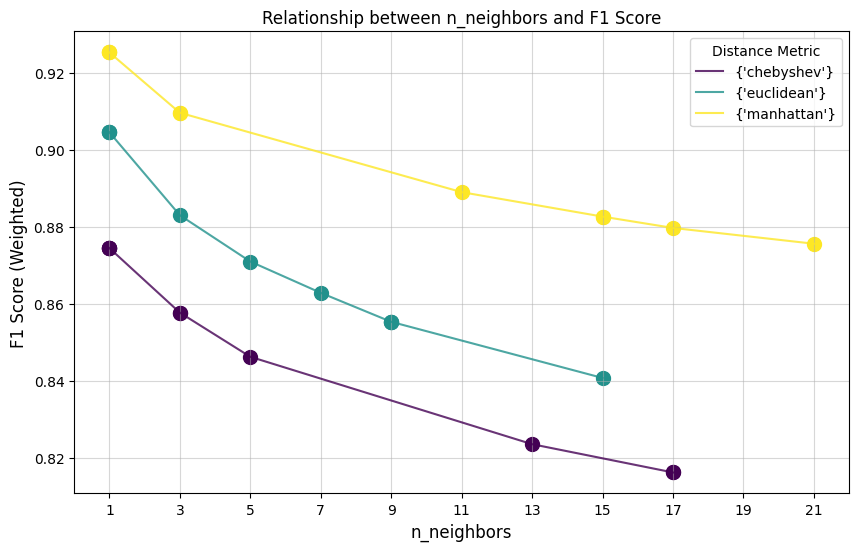

In [18]:
# Extract n_neighbors, F1 scores, and metric values for each trial
n_neighbors_values = [trial.params['n_neighbors'] for trial in study.trials if trial.value is not None]
f1_scores = [trial.value for trial in study.trials if trial.value is not None]
metrics = [trial.user_attrs['metric'] for trial in study.trials if trial.value is not None]

# Define unique colors for each metric using viridis
unique_metrics = sorted(set(metrics))  # Sorted for consistent ordering
colors = [to_hex(viridis(i / (len(unique_metrics) - 1))) for i in range(len(unique_metrics))]  # Assign distinct colors
color_map = dict(zip(unique_metrics, colors))

unique_n_neighbors = sorted(set(n_neighbors_values))
x_ticks = list(range(min(unique_n_neighbors), max(unique_n_neighbors) + 2, 2)) 

plt.figure(figsize=(10, 6))
for metric in unique_metrics:
    # Filter data for the current metric
    metric_indices = [i for i, m in enumerate(metrics) if m == metric]
    n_neighbors_metric = [n_neighbors_values[i] for i in metric_indices]
    f1_scores_metric = [f1_scores[i] for i in metric_indices]

    # Sort the points by n_neighbors for a smooth line
    sorted_indices = sorted(range(len(n_neighbors_metric)), key=lambda k: n_neighbors_metric[k])
    n_neighbors_metric = [n_neighbors_metric[i] for i in sorted_indices]
    f1_scores_metric = [f1_scores_metric[i] for i in sorted_indices]

    # Plot line and scatter points
    plt.plot(
        n_neighbors_metric,
        f1_scores_metric,
        label={metric},
        color=color_map[metric],
        linestyle='-',
        alpha=0.8
    )
    plt.scatter(
        n_neighbors_metric,
        f1_scores_metric,
        color=color_map[metric],
        s=100, 
    )

plt.legend(title="Distance Metric", loc="best")

# Format plot
plt.xticks(x_ticks, fontsize=10)  # Set evenly spaced x-axis ticks
plt.yticks(fontsize=10)
plt.xlabel('n_neighbors', fontsize=12)
plt.ylabel('F1 Score (Weighted)', fontsize=12)
plt.title('Relationship between n_neighbors and F1 Score')
plt.grid(True, alpha=0.5)

# Show the plot
plt.show()

kNN has key hyperparameters like n_neighbors (number of neighbors) and metric (distance measure). The performance of kNN is highly sensitive to these choices. Optuna was used to automate the hyperparameter tuning process by maximizing the F1-weighted score through cross-validation. Automated tuning ensures the model achieves its best performance without manual trial and error. The use of cross-validation ensures that the chosen hyperparameters generalize well to unseen data.

In [24]:
# train the KNN model with the optimized hyperparameters
best_trial = study.best_trial
best_metric = best_trial.user_attrs["metric"]

knn_model = neighbors.KNeighborsClassifier(
    n_neighbors=best_trial.params['n_neighbors'],  
    metric=best_metric, 
    weights='distance',
    n_jobs=-1  # Use all CPU cores for faster computation
)

knn_model.fit(X_train, y_train)

KNeighborsClassifier(metric='manhattan', n_jobs=-1, n_neighbors=1,
                     weights='distance')

In [25]:
# Make predictions on the test set
y_pred = knn_model.predict(X_test)

In [29]:
# Evaluate the model using various metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')
conf_matrix = confusion_matrix(y_test, y_pred)

# Print evaluation metrics
print("Model Evaluation Metrics:")
print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1 Score: {f1:.2f}")
print(f"\nConfusion Matrix:\n{conf_matrix}")

# Print classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=["Not Fraud", "Fraud"]))

Model Evaluation Metrics:
Accuracy: 0.88
Precision: 0.92
Recall: 0.88
F1 Score: 0.90

Confusion Matrix:
[[18656  1822]
 [  798   402]]

Classification Report:
              precision    recall  f1-score   support

   Not Fraud       0.96      0.91      0.93     20478
       Fraud       0.18      0.34      0.23      1200

    accuracy                           0.88     21678
   macro avg       0.57      0.62      0.58     21678
weighted avg       0.92      0.88      0.90     21678

